# Exercise 3
### Peder Brekke, Simen Nesland and Espen Bjørge Urheim

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy as sp
sns.set()

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [2]:
# Define initial conditions
def init_1(x, K):
    return np.maximum(np.ones(len(x))*K-x, np.zeros(len(x)))

def init_2(x, K):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]-K >= 0:
            y[i] = 1
    return y

def plot_solution(x, t, U, dim = (7,7), txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_figheight(dim[0])
    fig.set_figwidth(dim[1])
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)   # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    ax.zaxis.labelpad = -15
    plt.title(txt)

def tridiag(v, d, w, N):
    # Help function (copied from exercise 2)
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

We look at the Black-Scholes $(BS)$ partial differential equation,

$$
u_t-\frac{1}{2}\sigma^2x^2u_{xx}-rxu_x+cu=0,
$$

which we want to solve numerically. To do so, we first discretize the equation using central differences in space,

$$
u_{xx}^n\approx\frac{U_{m+1}^n-2U_m^n+U_{m-1}^n}{h^2}, \,\, u_{x}^n\approx \frac{U_{m+1}^n-U_{m-1}^n}{2h}.
$$

This yields the space-discretized equation

$$
u_t^n \approx \frac{1}{2}\sigma^2x^2\frac{U_{m+1}^n-2U_m^n+U_{m-1}^n}{h^2}+rx \frac{U_{m+1}^n-U_{m-1}^n}{2h}-cU_m^n
$$

We solve this numerically using the Crank-Nicolson method,

$$
\vec{y}^{n+1}=\vec{y}^n+\frac{k}{2}\bigg[\vec{f}\big(t^n, \vec{y}^n\big)+\vec{f}\big(t^{n+1}, \vec{y}^{n+1}\big)\bigg], \,\, \vec{f}\big(t^n, \vec{y}^n\big) = \vec{f}_n:= u_t^n.
$$

Inserting the approximations for $\vec{f}_n$ and $\vec{f}_{n+1}$, we get

$$
U_m^{n+1} = U_m^n + \frac{k}{2}\Big(\frac{1}{2}\sigma^2x^2\frac{U_{m+1}^n-2U_m^n+U_{m-1}^n}{h^2}+rx \frac{U_{m+1}^n-U_{m-1}^n}{2h}-cU_m^n
            +\frac{1}{2}\sigma^2x^2\frac{U_{m+1}^{n+1}-2U_m^{n+1}+U_{m-1}^{n+1}}{h^2}+rx \frac{U_{m+1}^{n+1}-U_{m-1}^{n+1}}{2h}-cU_m^{n+1}\Big)
$$

$$
\Rightarrow 
\bigg(-\frac{k\sigma^2 x^2}{4h^2}+\frac{rkx}{4h}\bigg)U_{m-1}^{n+1}+\bigg(1+\frac{k\sigma^2x^2}{2h^2}-\frac{kc}{2}\bigg)U_m^{n+1}+\bigg(-\frac{k\sigma^2 x^2}{4h^2}-\frac{rkx}{4h}\bigg)U_{m+1}^{n+1}
= 
\bigg(\frac{k\sigma^2 x^2}{4h^2}-\frac{rkx}{4h}\bigg)U_{m-1}^{n}+\bigg(1-\frac{k\sigma^2x^2}{2h^2}-\frac{kc}{2}\bigg)U_m^{n}+\bigg(\frac{k\sigma^2 x^2}{4h^2}+\frac{rkx}{4h}\bigg)U_{m+1}^{n}
$$

We implement this in matrix form, $C_{n+1}\vec{U}^{n+1}=C_n\vec{U}^n+\vec{b}$, where $C_{n+1}$ and $C_n$ are $(M-1)\times(M-1)$ tridiagonal matrices and $\vec{b}$ contains the boundary contributions, which are not included in the matrices. We find the boundary contributions by inserting for $m=1$ and $m=M-1$ in the equation above and look at the terms including $U_0$ and $U_M$, which results in the two conditions

$$
b_1=\big(\frac{k\sigma^2x^2}{4h^2}-\frac{rkx}{4h} \big)\big(g_0(t_n)+g_0(t_{n+1}\big)\\
b_{M-1}=\big(\frac{k\sigma^2x^2}{4h^2}+\frac{rkx}{4h} \big)\big(g_1(t_n)+g_1(t_{n+1}\big)\\
$$

where $g_0(t_n)$ and $g_1(t_n)$ are boundary conditions at time step $n$ at $x=0$ and $x=M$, respectively. We implement this in the function `crank_nicolson()`.

In [3]:
# a)
def crank_nicolson(g, sigma = 0.3, c = 0.03, r = 0.03, K = 110, M=50, N=400, R = 200, T=1):
    h = R/(M)     # Stepsize in space
    k = T/(N)     # Stepsize in time

    # Print stepsizes and r
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x, K)           # Initial values
    
    # Boundary conditions
    U[-1,:] = np.zeros(N+1)    # Artificial boundary conditions (x = R)
    L = g(np.zeros(1), K)[0]
    U[0,:] = L*np.exp(-c*t)

    # Make tridiagonal matrices using the derived formula
    beta = k/(4*h**2)*sigma**2*x[2:-1]**2-r*k*x[2:-1]/(4*h)             # Lower diagonal
    alpha = -k/(2*h**2)*sigma**2*x[1:-1]**2-k*c/2*np.ones_like(x[1:-1]) # Diagonal
    gamma = k/(4*h**2)*sigma**2*x[1:-2]**2+r*k*x[1:-2]/(4*h)            # Upper diagonal

    C_n = np.diag(beta, k=-1)+np.diag(1+alpha) + np.diag(gamma, k=1)
    C_n1 = np.diag(-beta, k=-1)+np.diag(1-alpha) + np.diag(-gamma, k=1)
    
    # Calculate U iteratively
    for n in range(1,N+1):
        if n%20 == 0:
            print(f"{100*n/(N+1):.3f} %", end="\r")
        b = np.zeros(M-1)
        b[0] = k/4*((sigma*x[0])**2/h**2 - r*x[0]/h)*(U[0, n] + U[0,n-1])
        b[-1] = k/4*((sigma*x[-1])**2/h**2 + r*x[-1]/h)*(U[-1, n] + U[-1,n-1])
        U[1:-1,n] = np.linalg.solve(C_n1, C_n@U[1:-1, n-1]+b)

    return x,t,U

h=1.5000, k=0.0100


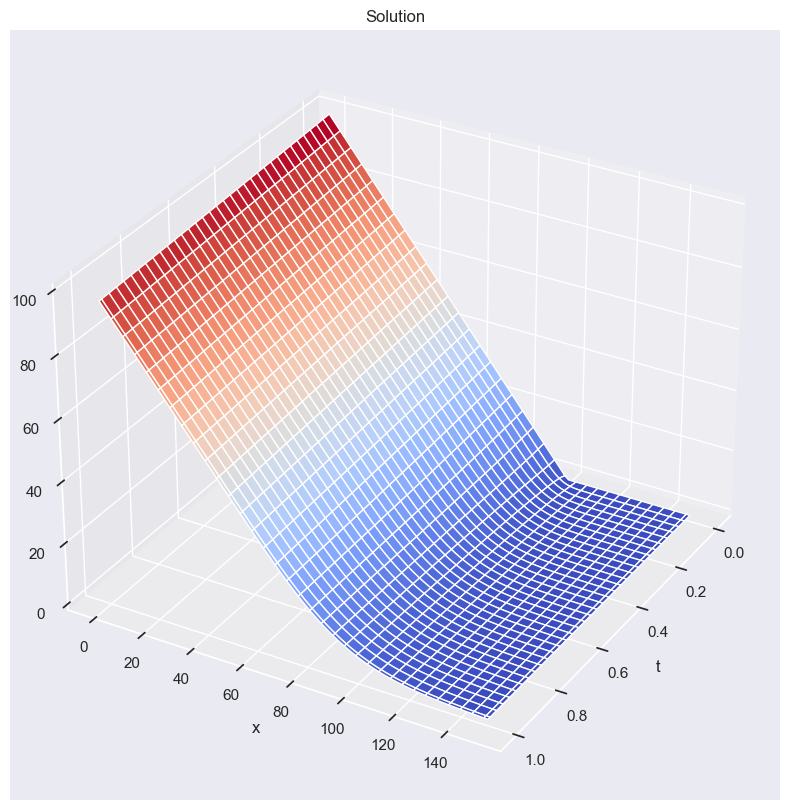

In [4]:
r = 0.05
x,t,U = crank_nicolson(init_1, sigma=np.sqrt(r)+1.e-3, r = r, c = 0.05, T = 1, M = 100, N = 100, R = 150, K = 100)
plot_solution(x, t, U, dim = (10,10))

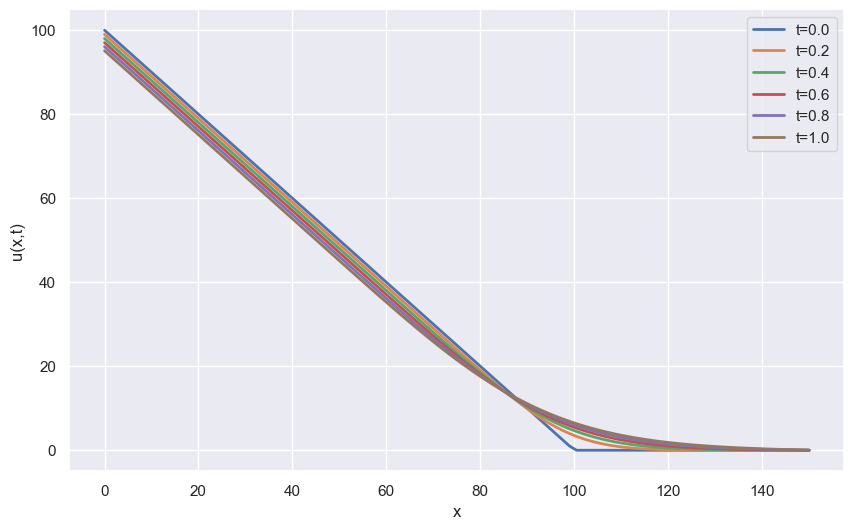

In [5]:
# Plot the solution at some points in time
plt.figure(figsize=(10,6))
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,U[:,n],label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

In [6]:
def rhs_std(x, t):
    return 0

#def rhs_uex_1(x, t):
    a = -np.exp(-t)*np.sin(np.pi*x) + 1/2*sigma**2*x**2 * (np.pi**2*np.exp(-t)*np.sin(np.pi*x))\
    -r*x*np.pi*np.exp(-t)*np.cos(np.pi*x) + c*np.exp(-t)*np.sin(np.pi*x)
    return a
    
#def uex_1(x,t):  
    return np.exp(-t)*np.sin(np.pi*x)

def rhs_uex_1(x,t):
    return -np.cos(x)*np.sin(t) + 1/2*sigma**2*x**2*np.cos(x)*np.cos(t) + r*x*np.sin(x)*np.cos(t) + c*np.cos(x)*np.cos(t)

def uex_1(x,t):
    return np.cos(x)*np.cos(t)

#def rhs_uex_1(x,t):
    return -x**3*np.sin(t) + c*x**3*np.cos(t) - 3*r*x**3*np.cos(t) - 3*sigma**2*x**3*np.cos(t)

#def uex_1(x,t):
    return np.cos(t)*x**3

In [7]:
#e)

def crank_nicolson2(g, sigma = 0.3, c = 0.03, r = 0.03, K = 110, M=50, N=400, R = 200, T=1, rhs = rhs_std):
    h = R/(M)     # Stepsize in space
    k = T/(N)     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x,0)            # Initial values
    
    # Boundary conditions
    U[-1,:] = g(x[-1],t)    # Artificial boundary conditions (x = R)
    U[0,:] = g(x[0],t)

    # Make tridiagonal matrices using the derived formula
    beta = k/(4*h**2)*sigma**2*x[2:-1]**2-r*k*x[2:-1]/(4*h)             # Lower diagonal
    alpha = -k/(2*h**2)*sigma**2*x[1:-1]**2-k*c/2*np.ones_like(x[1:-1]) # Diagonal
    gamma = k/(4*h**2)*sigma**2*x[1:-2]**2+r*k*x[1:-2]/(4*h)            # Upper diagonal

    C_n = np.diag(beta, k=-1)+np.diag(1+alpha) + np.diag(gamma, k=1)
    C_n1 = np.diag(-beta, k=-1)+np.diag(1-alpha) + np.diag(-gamma, k=1)

    
    # Calculate U iteratively
    for n in range(1,N+1):
        if n%20 == 0:
            print(f"{100*n/(N+1):.3f} %", end="\r")
        b = np.zeros(M-1)
        b[0] = k/4*((sigma*x[1])**2/h**2 - r*x[1]/h)*(U[0, n] + U[0,n-1])
        b[-1] = k/4*((sigma*x[-2])**2/h**2 + r*x[-2]/h)*(U[-1, n] + U[-1,n-1])
        U[1:-1,n] = np.linalg.solve(C_n1, C_n@U[1:-1, n-1]+b + k/2*(rhs(x[1:-1],t[n-1]) + rhs(x[1:-1],t[n])))
    print(f"{100:.3f} %", end="\r")

    return x,t,U


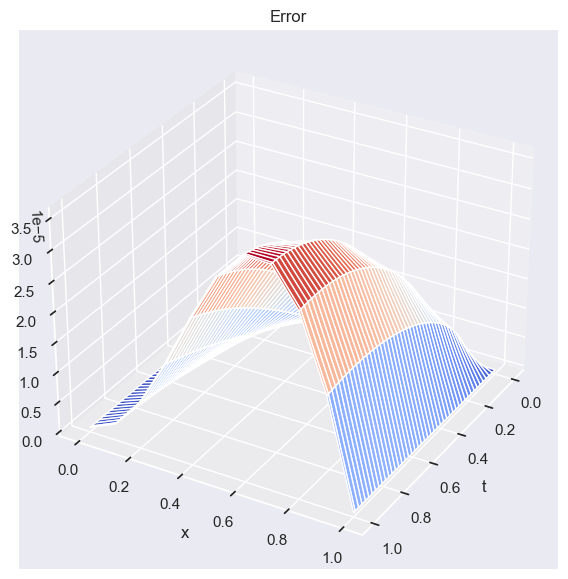

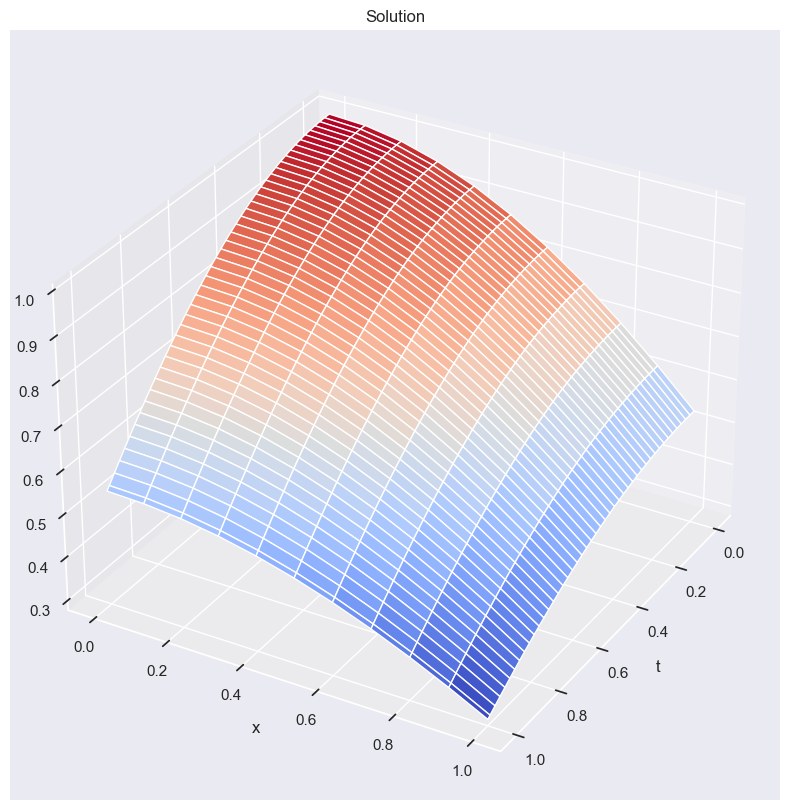

In [8]:
# Make a 3-d plot of the errorM = 10
M = 10
N = 400
T = 1
sigma = 0.5
r = 0.05
c = 0.15
R = 1
K = 5
H = 0.5


x,t,U = crank_nicolson2(uex_1, sigma=sigma, r = r, c = c, T = T, M = M, N = N, R = R, K = K, rhs = rhs_uex_1)
TT, XX = np.meshgrid(t,x)
plot_solution(x, t, U-uex_1(XX,TT), txt='Error')
plot_solution(x, t, U, dim = (10,10))
plt.show()

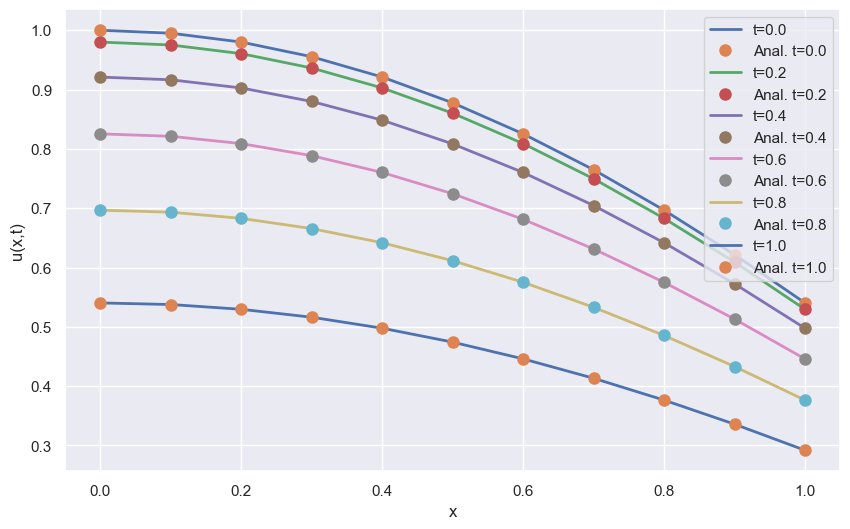

In [9]:
# Plot the solution at some points in time
tsss = np.linspace(0,T,N+1)
plt.figure(figsize=(10,6))
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,U[:,n],label='t={:.1f}'.format(tn))
    plt.plot(x,uex_1(x,tn),'o',label='Anal. t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

# NYTT FRA SIMPERN:

## e) Analytic solution and convergence

We will now test our numerial scheme by introducing a test-solution. Choosing $u(x,t)=\cos{t}\cos{x}$ we can use the Black Scholes equation to find the corresponding RHS. Below are the results from the implementation.

In [10]:
# Functions for testing

def rhs_std(x, t):
    return 0

#def rhs_uex_1(x, t):
    a = -np.exp(-t)*np.sin(np.pi*x) + 1/2*sigma**2*x**2 * (np.pi**2*np.exp(-t)*np.sin(np.pi*x))\
    -r*x*np.pi*np.exp(-t)*np.cos(np.pi*x) + c*np.exp(-t)*np.sin(np.pi*x)
    return a
    
#def uex_1(x,t):  
    return np.exp(-t)*np.sin(np.pi*x)

# RHS of BS
def rhs_uex_1(x,t):
    return -np.cos(x)*np.sin(t) + 1/2*sigma**2*x**2*np.cos(x)*np.cos(t) + r*x*np.sin(x)*np.cos(t) + c*np.cos(x)*np.cos(t)

# Exact solution
def uex_1(x,t):
    return np.cos(x)*np.cos(t)

#def rhs_uex_1(x,t):
    return -x**3*np.sin(t) + c*x**3*np.cos(t) - 3*r*x**3*np.cos(t) - 3*sigma**2*x**3*np.cos(t)

#def uex_1(x,t):
    return np.cos(t)*x**3

In [11]:
# New scheme with RHS
def crank_nicolson2(g, sigma = 0.3, c = 0.03, r = 0.03, K = 110, M=50, N=400, R = 200, T=1, rhs = rhs_std):
    """
    Same Crank-Nicolson scheme, but with possibility of RHS.
    """
    h = R/(M)     # Stepsize in space
    k = T/(N)     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x,0)            # Initial values
    
    # Boundary conditions
    U[-1,:] = g(x[-1],t)    # Artificial boundary conditions (x = R)
    U[0,:] = g(x[0],t)

    # Make tridiagonal matrices using the derived formula
    beta = k/(4*h**2)*sigma**2*x[2:-1]**2-r*k*x[2:-1]/(4*h)             # Lower diagonal
    alpha = -k/(2*h**2)*sigma**2*x[1:-1]**2-k*c/2*np.ones_like(x[1:-1]) # Diagonal
    gamma = k/(4*h**2)*sigma**2*x[1:-2]**2+r*k*x[1:-2]/(4*h)            # Upper diagonal

    C_n = np.diag(beta, k=-1)+np.diag(1+alpha) + np.diag(gamma, k=1)
    C_n1 = np.diag(-beta, k=-1)+np.diag(1-alpha) + np.diag(-gamma, k=1)

    
    # Calculate U iteratively
    for n in range(1,N+1):
        if n%20 == 0:
            print(f"{100*n/(N+1):.3f} %", end="\r")
        b = np.zeros(M-1)
        b[0] = k/4*((sigma*x[1])**2/h**2 - r*x[1]/h)*(U[0, n] + U[0,n-1])
        b[-1] = k/4*((sigma*x[-2])**2/h**2 + r*x[-2]/h)*(U[-1, n] + U[-1,n-1])
        U[1:-1,n] = np.linalg.solve(C_n1, C_n@U[1:-1, n-1]+b + k/2*(rhs(x[1:-1],t[n-1]) + rhs(x[1:-1],t[n])))
    print(f"{100:.3f} %", end="\r")

    return x,t,U

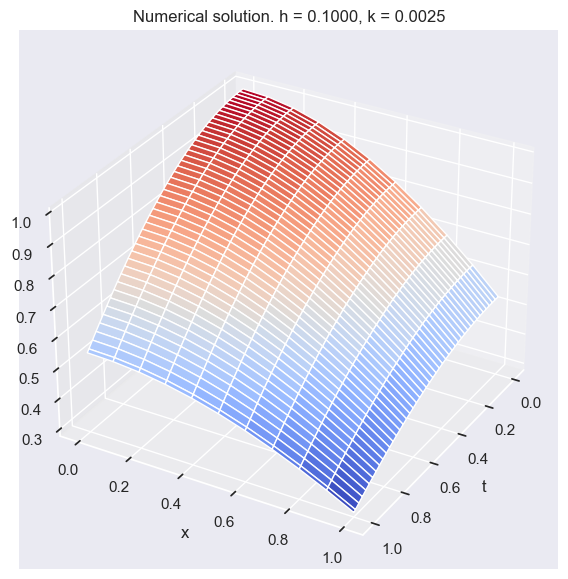

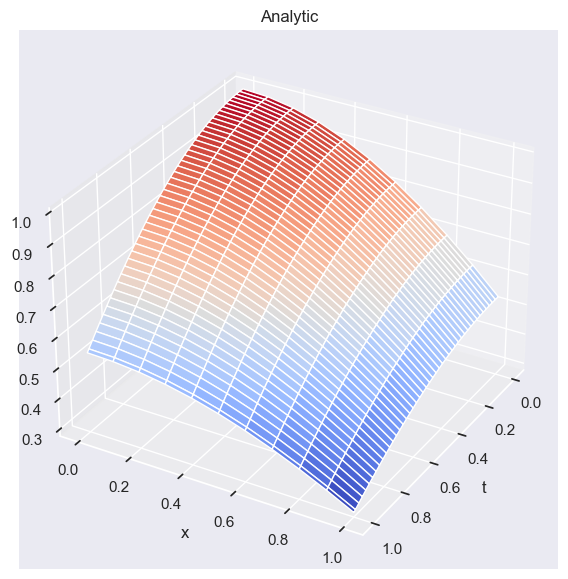

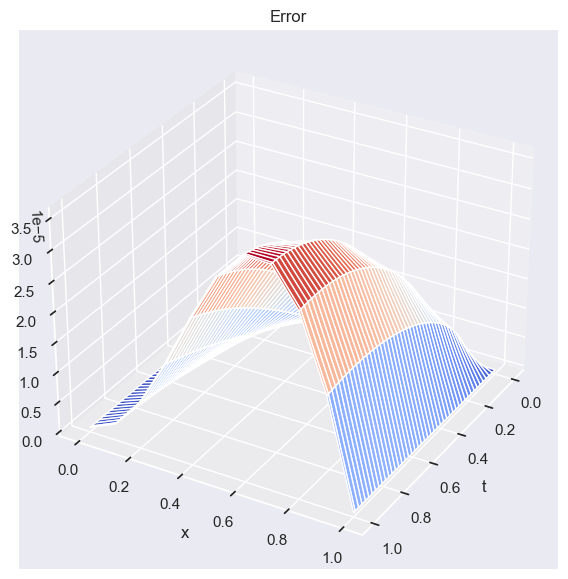

In [12]:
# Plotting solutions
M = 10
N = 400
T = 1
sigma = 0.5
r = 0.05
c = 0.15
R = 1
K = 5
H = 0.5
x,t,U = crank_nicolson2(uex_1, sigma=sigma, r = r, c = c, T = T, M = M, N = N, R = R, K = K, rhs = rhs_uex_1)

TT, XX = np.meshgrid(t,x)
plot_solution(x,t,U, txt=f"Numerical solution. h = {R/M:.4f}, k = {T/N}")
plot_solution(x, t, uex_1(XX,TT), txt='Analytic')
plot_solution(x, t, U-uex_1(XX,TT), txt='Error')

Overall the numerical implementation looks very solid. To test the actual convergence, we use different stepsizes and compare with the analytic solution. Since Crank-Nicolson is of order $2$, this is the expected result. Below are the results.

Testing: 

Stepsize 1
100.000 %

Stepsize 2
100.000 %

Stepsize 3
100.000 %

Stepsize 4


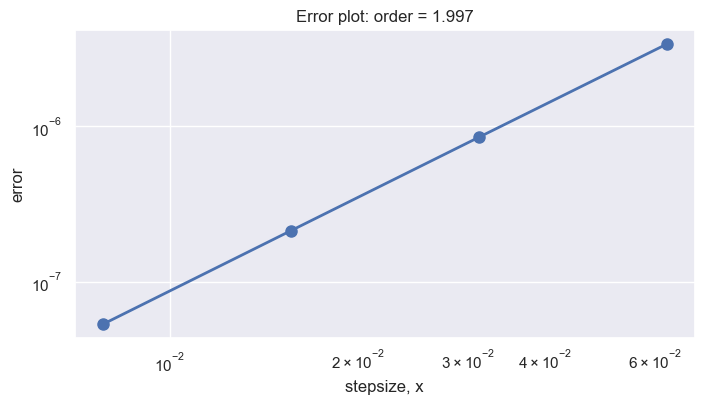

In [13]:
def convergence_x(u_exact, rhs, solver=crank_nicolson2, R=R, K = K, T = T, N = N, K_max = 4, norm = np.inf):
    """
    Calculates errors for different values of M, i.e. stepsizes in spatial domain.
    Returns array of stepsizes, errors and order of fitted curve in log-log
    """

    errs = np.zeros(K_max)
    hs = np.zeros(K_max)

    M = 16
    
    print("Testing: ", end="")
    for l in range(K_max):
        print(f"\n\nStepsize {l+1}")     
        x, t, U = solver(u_exact, sigma = sigma, r = r, c = c, T = 0.1, M = M, N = 10000, R = R,
                         K = K, rhs = rhs)

        hs[l] = 1/M
        errs[l] = np.linalg.norm(U[:,-1] - u_exact(x,t[-1]), norm)
        
        M *= 2

    order = np.polyfit(np.log(hs),np.log(errs),1)[0]
    return hs, errs, round(order, 3)

H, E, order = convergence_x(uex_1, rhs_uex_1)
plt.loglog(H,E, 'o-')
plt.title(f"Error plot: order = {order}")
plt.xlabel("stepsize, x")
plt.ylabel("error")
plt.show()

Finding refrence solution:
Testing: 

Stepsize 1
100.000 %

Stepsize 2
100.000 %

Stepsize 3
100.000 %

Stepsize 4
100.000 %

Stepsize 5
100.000 %

Stepsize 6


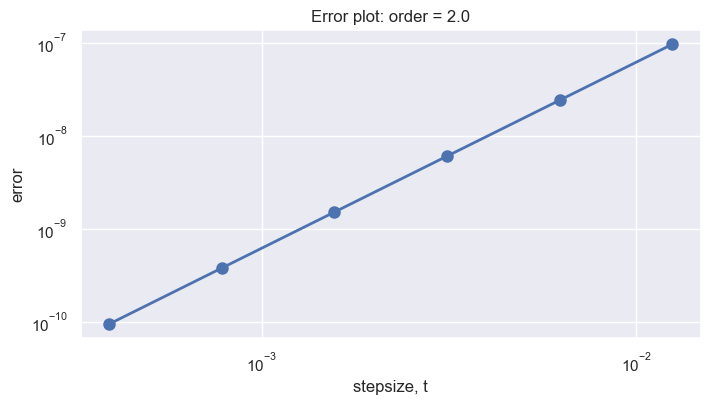

In [14]:
def convergence_t(u_exact, rhs, solver=crank_nicolson2, R=1, K = 0.5, T = 0.1, N = 10000, K_max = 6, norm = np.inf):
    """
    Calculates errors for different values of N, i.e. stepsizes in temporal domain.
    Returns array of stepsizes, errors and order of fitted curve in log-log
    """

    M = 50
    print("Finding refrence solution:")
    x_ref, t_ref, U_ref = solver(u_exact, sigma = np.sqrt(0.15)+1.e-3, r = 0.15, c = 0.05, T = T, M = M, N = N, R = R,
                         K = 0.5, rhs = rhs)

    errs = np.zeros(K_max)
    hs = np.zeros(K_max)

    N = 8
    print("Testing: ", end="")
    for l in range(K_max):
        print(f"\n\nStepsize {l+1}")     
        x, t, U = solver(u_exact, sigma = np.sqrt(0.15)+1.e-3, r = 0.15, c = 0.05, T = T, M = M, N = N, R = R,
                         K = 0.5, rhs = rhs)

        hs[l] = T/N
        errs[l] = np.linalg.norm(U[:,-1] - U_ref[:,-1], norm)
        
        N *= 2
        
    order = np.polyfit(np.log(hs),np.log(errs),1)[0]
    return hs, errs, round(order, 3)

Ks, E, order = convergence_t(uex_1, rhs_uex_1)
plt.loglog(Ks,E, 'o-')
plt.title(f"Error plot: order = {order}")
plt.xlabel("stepsize, t")
plt.ylabel("error")
plt.show()

The results correspond very well to the expected $O(h^2 + k^2)$.

### f)

We will now look at the effect on the error, of changing the value of $R$. However, we will only investegate the error on the interval $\left[0,2K \right]$. Below are our results.

h=1.0000, k=0.0010
h=0.4200, k=0.0010
h=0.5000, k=0.0010
h=0.5800, k=0.0010
h=0.6600, k=0.0010
h=0.7400, k=0.0010
h=0.8200, k=0.0010


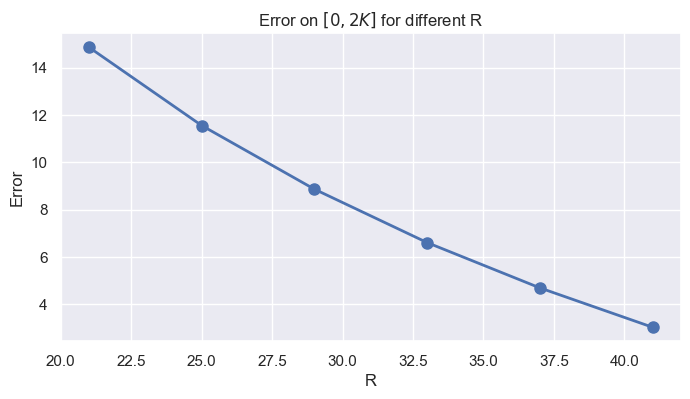

In [15]:
# Refrence solution
x_ref_R, t_ref_, U_ref_R = crank_nicolson(init_1, K = 10, R = 50, N = 1000, M = 50)

errs = np.zeros(6)
rs = np.zeros(6)
K=10
M=50

# Tests for different values of R
i = 0
for R in range(21, 42, 4):
    x_R, t_R, U = crank_nicolson(init_1, K = 10, R = R, N = 1000, M = 50)

    index = int((2*K*(M+1))/R)
    errs[i] = np.linalg.norm(U[:index,-1] - U_ref_R[:index,-1])
    rs[i] = R
    i += 1

# Plotting results
plt.figure()
plt.plot(rs,errs,"o-")
plt.xlabel("R")
plt.ylabel("Error")
plt.title("Error on $[0,2K]$ for different R")
plt.show()

There is a clear tendency to lower error for greater $R$. This is expected because the introduction of an artificial boundary condition has effect on the solution. The closer to $R$, the greater the effect. Thus, increasing $R$, and still looking at the same interval, decreases the error since the effects of the boundary condition decays with distance from the boundary.